# EXPLORATORY DATA ANALYSIS (EDA)

## Preface

...

## Prerequisites:
Make sure thanhhoa_processed.csv is located in data/processed. If not, run script files
...

## [Code] Load dependencies, dataset; Declare constants

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Dependencies loaded successfully")

path = "../data/processed/thanhhoa_processed.csv"
df = pd.read_csv(path, index_col="STT") # I didn't declare SBD and MA_TINH as `dtype = str` here as in script files, because no entries begin with leading zeros

print("Dataset loaded successfully")

SUBJ = ["TOAN", "VAN", "LI", "HOA", "SINH", "SU", "DIA", "KTPL", "T_ANH"]
COMB = ["A00", "A01", "B00", "C00", "D01"]

print("Constant lists declared")

Dependencies loaded successfully
Dataset loaded successfully
Constant lists declared


## [Code] Compare score distributions of subjects

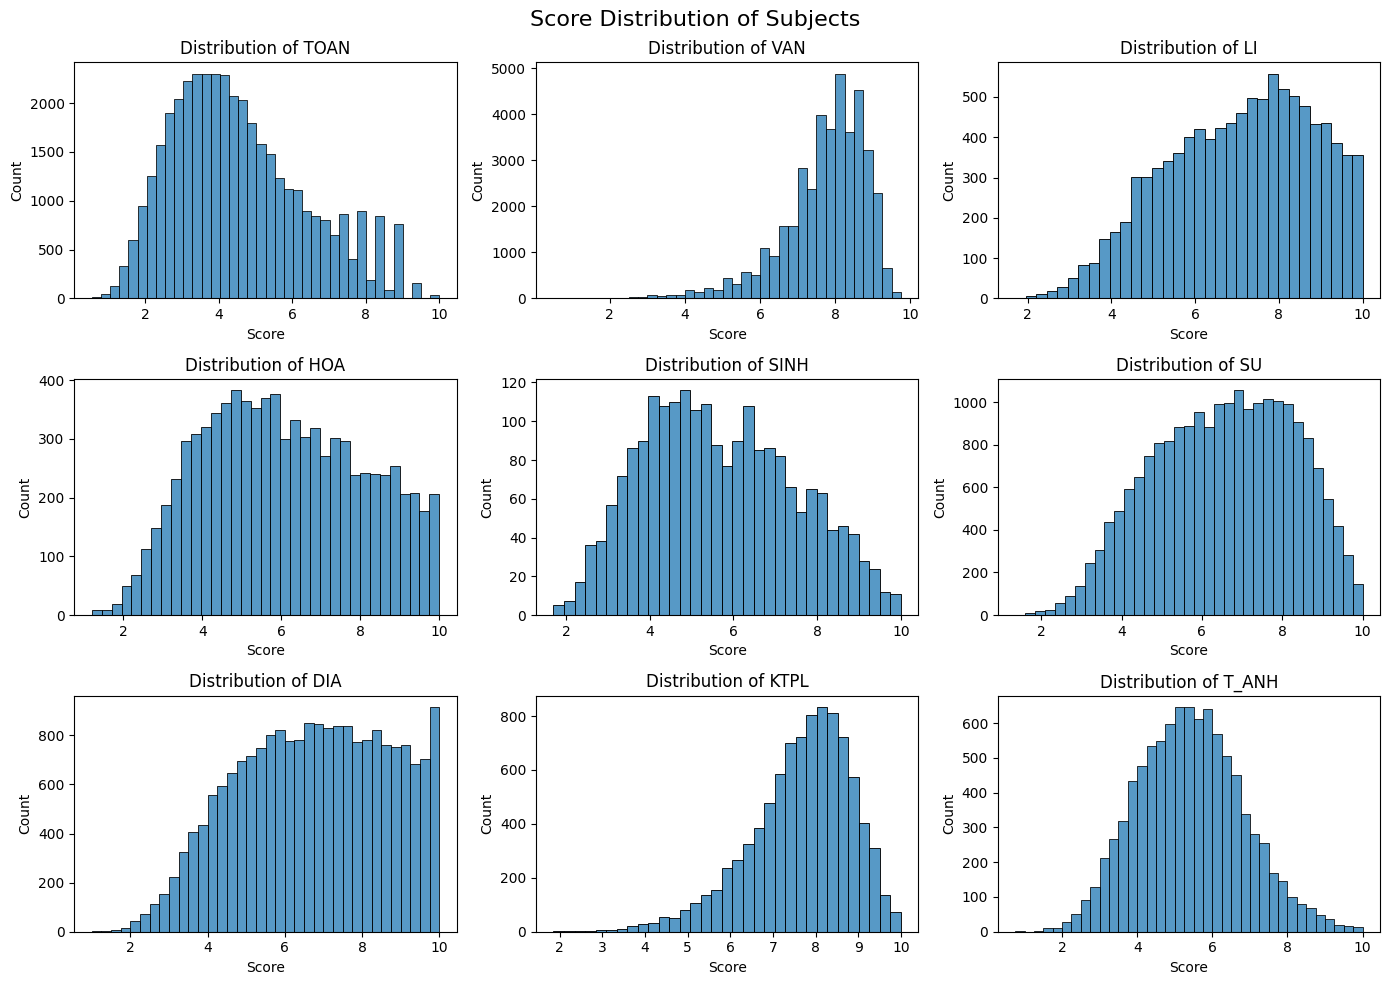

In [138]:
fig, axes = plt.subplots(3, 3, figsize=(14, 10))

for ax, subj in zip(axes.flat, SUBJ):
    sns.histplot(df[subj], kde=False, bins=30, ax=ax, binwidth=0.25)
    ax.set_title(f"Distribution of {subj}")
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")

plt.suptitle("Score Distribution of Subjects", fontsize=16)
plt.tight_layout()
plt.show()

Takeaway:
- Test difficulty is not standardized across subjects. Some are left-skewed (`TOAN` - Math), while some are right-skewed (`KTPL` - Econs and Law).
- `T_ANH` shows textbook bell-curve distribution => good
=> 

## [Code] Compare score distributions of subject combinations

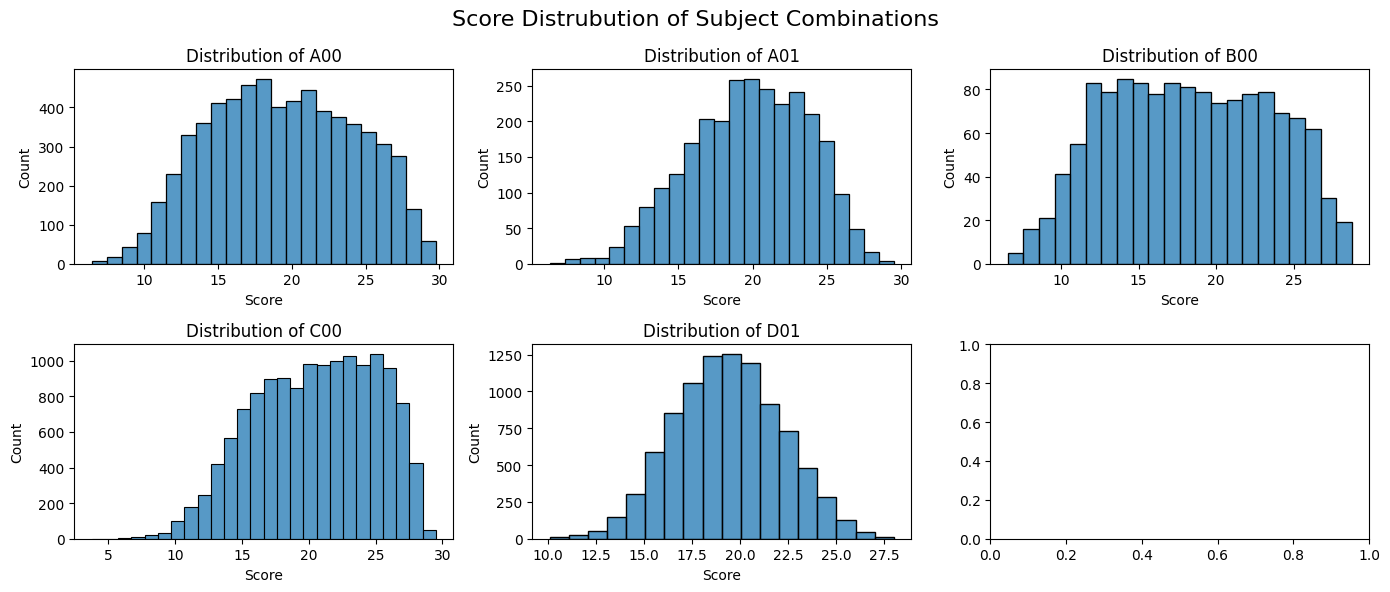

In [135]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6))

for ax, subj in zip(axes.flat, COMB):
    sns.histplot(df[subj], kde=False, bins=30, ax=ax, binwidth=1)
    ax.set_title(f"Distribution of {subj}")
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")

plt.suptitle("Score Distrubution of Subject Combinations", fontsize=16)
plt.tight_layout()
plt.show()

## [Code] Correlation matrix of test results

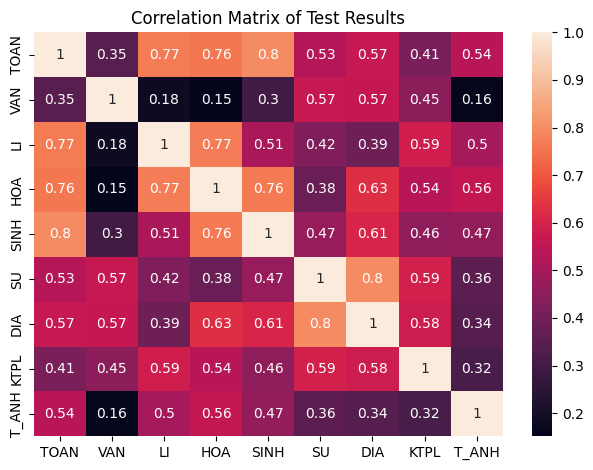

In [136]:
subjects = ["TOAN", "VAN", "LI", "HOA", "SINH", "SU", "DIA", "KTPL", "T_ANH"]

correlation_matrix = df[subjects].corr()

plt.figure()
plt.title("Correlation Matrix of Test Results")
sns.heatmap(data=correlation_matrix, annot=True)
plt.tight_layout()
plt.show()

### Insights

- No negative correlation => ...
- Students perform well on TOAN (Math) are likely to perform well on Natural Science subjects: LI (Physics), HOA (Chemistry), SINH (Biology). But no high correlation between Physics and Biology. 
- Also notable high corr: SU (History) and DIA (Geography)